# Continuous action spaces

So far, our code works with a discrete action space (such as actions "left", "right"), but not with continuous actions (e.g., indicating the strength of "left" or "right" actions).

You can see the difference here:

In [1]:
import numpy as np
import torch
import gymnasium as gym

In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
env.close()
env = gym.make("MountainCarContinuous-v0")
print(env.action_space)
env.close()


Discrete(2)
Box(-1.0, 1.0, (1,), float32)


Here, `Discrete(2)` means there are two actions (0 and 1), while `Box(-1.0, 1.0, (1,))` means there is one action in the interval [-1, 1].

We therefore need an approach to find the best action in a bounded interval. We'll do this using normal distributions restricted to the interval. We want to optimize the parameters of the distribution, so we need to understand the gradient of the mean and standard deviation of the distribution.

## Normal distribution on unbounded action space

The probability density of a normal distribution with parameterized mean and standard deviation is (see e.g., Sutton & Barto, page 335):

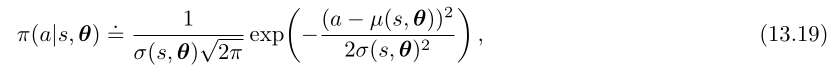

In [ ]:
# PyTorch implementation of normal distribution over action space and loss for REINFORCE
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Initialise the environment
env = gym.make("BipedalWalker-v3") # This environment is chosen in this example because it has a continuous action space with more than 1 dimension
observation, info = env.reset(seed=seed)

means   = torch.tensor([0.5, 0.5, 0.9,  0.9],  requires_grad=True) # some means
stddevs = torch.tensor([0.1, 1.0, 0.01, 0.01], requires_grad=True) # some standard deviations

m = torch.distributions.Normal(means, stddevs)

action = m.sample()
print("Action:", action)

# The difference between rsample and sample is that the output of .sample() does not have a gradient,
# while the output of .rsample() has:

print("Does the .sample()'d action require grad?", action.requires_grad)
print("Does the .rsample()'d action require grad?", m.rsample().requires_grad)

# This means that in the derivative dp(a) / dmu for .sample() the variable a is treated as fixed, 
# while for .rsample() a is seen as a function of mu and sigma: a = sigma * noise + mu, 
# where noise is sampled from a standard normal distribution.

next_state, reward, terminated, truncated, info = env.step(action.detach().numpy())

log_prob = m.log_prob(action)
print("\nlog_prob:", log_prob)

loss = -reward * log_prob.sum()
print("Loss:", loss)

loss.backward()

print("means.grad:", means.grad)
print("stddevs.grad:", stddevs.grad)

env.close()

Action: tensor([0.5337, 0.6288, 0.9023, 0.9023])
Does the .sample()'d action require grad? False
Does the .rsample()'d action require grad? True

log_prob: tensor([ 1.3270, -0.9272,  3.6587,  3.6597], grad_fn=<SubBackward0>)
Loss: tensor(0.3781, grad_fn=<MulBackward0>)
means.grad: tensor([0.1649, 0.0063, 1.1486, 1.1283])
stddevs.grad: tensor([-0.4343, -0.0482, -4.6294, -4.6388])


In [4]:
means, stddevs, action = means.detach().numpy(), stddevs.detach().numpy(), action.detach().numpy()

In [5]:
# Own calculation of gradients

# Taking log of the probability density of the normal distribution gives the log_probs
own_log_prob = -np.log(stddevs) - 0.5*np.log(2*np.pi) - (action - means)**2 / (2 * stddevs**2)
print("Own log_prob:", own_log_prob)
# To get the correct gradient for the case of action = m.rsample() instead of m.sample(), 
# one would need to substitute action = stdevs * eps + means for some eps ~ N(0, 1) 
# in this equation (eps has the same dimension as action).

own_loss = -reward * own_log_prob.sum()
print("Own loss:", own_loss)

own_means_grad = -reward * (action - means) / stddevs**2
print("Own means.grad:", own_means_grad)

own_stddevs_grad = -reward * ((action - means)**2 - stddevs**2) / stddevs**3
print("Own stddevs.grad:", own_stddevs_grad)

Own log_prob: [ 1.3269664 -0.9272345  3.6587458  3.6597056]
Own loss: 0.37808990672120113
Own means.grad: [0.16493426 0.00630997 1.1485511  1.1283165 ]
Own stddevs.grad: [-0.43433726 -0.04817412 -4.6294003  -4.6388054 ]


Related discussions:

* https://www.reddit.com/r/reinforcementlearning/comments/olqtba/pytorch_score_function_vs_rsample_gradient_of/
* PyTorch code of sample(): https://github.com/pytorch/pytorch/blob/v2.9.1/torch/distributions/distribution.py#L167

## Normal distributions within a bounded action space

In some cases, actions cannot be arbitrarily large or small. For example, for "BipedalWalker-v3", the action space is 4-dimensional with each dimension bounded by -1 and 1. We therefore need to ensure that sampled actions do not fall outside these bounds.

There are several possibilities to achieve this:

* Simulate from a normal distribution, then truncate the values if necessary,
* Simulate from a modified normal distribution, where the probability of falling outside the allowed range is set to 0.

Both possibilities differ in the probability that is assigned to the boundary, and in how the gradients are computed outside the allowed range.

There exist other approaches to sampling from a bounded action space, for example [StableBaselines3](https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/distributions.py#L233) has a normal distribution followed by a tanh squashing operation to ensure actions lie within a given interval.

### Distributions of clipped normal and truncated normal distributions

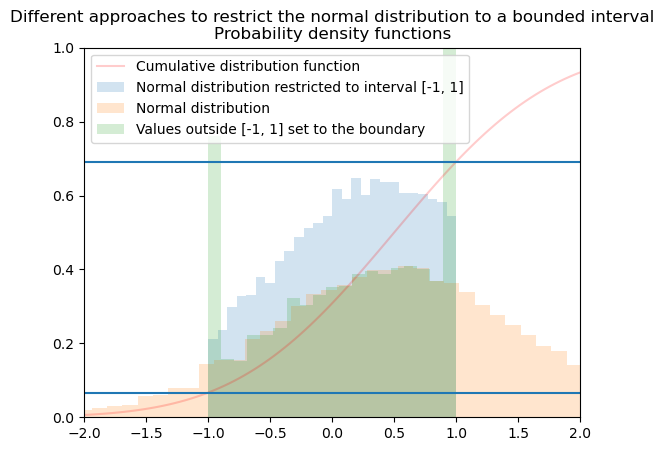

In [ ]:
# Using clamp / clip, values outside the allowed range are set to the boundary,
# this amounts to increasing the probability density (only) at the boundary.
# Instead, we want to uniformly increase the probability within the allowed range.
from scipy.stats import norm
from scipy.stats import uniform
import matplotlib.pyplot as plt
import numpy as np


# Generally, F^{-1}(uniform in [0,1]) is distributed as a random variable whose cumulative distribution function is F
# If we restrict the uniform distribution to [F(l), F(u)] for two numbers l and u,
# F^{-1}(this restricted uniform distribution) will be distributed according to a scaled distribution on [l, u].

l, u = -1, 1 # lower and upper bounds
mean, stddev = 0.5, 1 # parameters for (unrestricted) normal distribution

# Cumulative distribution function for normal distribution
F = norm.cdf([l, u], loc=mean, scale=stddev)

# Simulate from uniform distribution
rvs_U_restricted = uniform.rvs(F[0], F[1] - F[0], size=10000)

# Inverse of cumulative distribution function
rvs_Norm_restricted = norm.ppf(rvs_U_restricted, loc=mean, scale=stddev)

# For comparison, 1) simulate from (unrestricted) normal distribution
rvs_Norm = norm.rvs(loc=mean, scale=stddev, size=10000)

# and 2) set values of the (unrestricted) normal distribution which are outside the allowed range to the boundary
rvs_Norm_clipped = np.clip(rvs_Norm, l, u)

fig, ax = plt.subplots(1, 1)

# Normal CDF
ax.plot(np.linspace(l-1, u+1, 100), norm.cdf(np.linspace(l-1, u+1, 100), loc=mean, scale=stddev), 'r-', alpha=0.2, label="Cumulative distribution function")
# Normal CDF evaluated at the boundaries of the interval we want to restrict to
ax.hlines(F, l-1, u+1)
# The simulated vales for the restricted and unrestricted normal distributions
ax.hist(rvs_Norm_restricted, density=True,  bins='auto', histtype='stepfilled', alpha=0.2, label=f"Normal distribution restricted to interval [{l}, {u}]")
ax.hist(rvs_Norm, density=True,  bins='auto', histtype='stepfilled', alpha=0.2, label="Normal distribution")
ax.hist(rvs_Norm_clipped, density=True,  bins='auto', histtype='stepfilled', alpha=0.2, label=f"Values outside [{l}, {u}] set to the boundary")

ax.set_xlim([l-1, u+1])
ax.set_ylim([0, 1])

plt.title("Different approaches to restrict the normal distribution to a bounded interval\nProbability density functions")
ax.legend()

plt.show()

### Gradients of truncated normal distribution

In [7]:
# Gradients of mean and sigma, when interpreting a sample as a function of mean + sigma times some fixed random number
# The probability density of the truncated normal distribution is 0 outside of the allowed interval,
# and equal to the probability density of the normal distribution upscale by a constant factor within the interval.
# The log-probability is therefor -Inf outside the allowed interval, and inside the allowed interval is equal 
# to the log-probability of the normal distribution plus a constant.
# The constant is independent of mean or standard deviation, so it should not affect the log-probability within the interval.
# Let's verify this:
from torchrl.modules import TruncatedNormal

seed=42
torch.manual_seed(seed)

env = gym.make("BipedalWalker-v3")
observation, info = env.reset(seed=seed)


means   = torch.tensor([0.5, 0.5, 0.9, 0.9], requires_grad=True) # some means
stddevs = torch.tensor([0.1, 1.0, 0.01, 0.01], requires_grad=True) # some standard deviations

TN = TruncatedNormal(loc=means, scale=stddevs, low=0, high=1, tanh_loc=False)

action = TN.sample()
print("Action:", action)

next_state, reward, terminated, truncated, info = env.step(action.detach().numpy())

log_prob = TN.log_prob(action)
print("\nlog_prob:", log_prob)

loss = -reward * log_prob.sum()
print("Loss:", loss)

loss.backward()

print("means.grad:", means.grad)
print("stddevs.grad:", stddevs.grad)

Action: tensor([0.6186, 0.9095, 0.8970, 0.9174])

log_prob: tensor(6.4466, grad_fn=<SumBackward1>)
Loss: tensor(0.4436, grad_fn=<MulBackward0>)
means.grad: tensor([ 0.8163,  0.0282, -2.0501, 11.9902])
stddevs.grad: tensor([ 2.8041e-01,  5.9931e-03, -6.2695e+00,  1.4014e+01])


In [8]:
means, stddevs, action = means.detach().numpy(), stddevs.detach().numpy(), action.detach().numpy()

In [ ]:
# Own calculation of gradients

# Compared to the normal distribution, we need to scale the probability by 1 / probability of the normal distribution falling inside the allowed interval.
# For the log-prob, this means we need to add a log term (or subtract, because it's +log(1/something) = -log(something))
from scipy.stats import norm
F1 = norm.cdf(1, loc=means, scale=stddevs)
F0 = norm.cdf(0, loc=means, scale=stddevs)
log_prob_correction = -np.log(F1 - F0)


# Same log-probs as for the normal distribution, plus the correction
own_log_prob = -np.log(stddevs) - 0.5*np.log(2*np.pi) - (action - means)**2 / (2 * stddevs**2) + log_prob_correction

print("Own log_prob:", own_log_prob.sum())

own_loss = -reward * own_log_prob.sum()
print("Own loss:", own_loss)

# We need to correct the gradients as well
# https://math.stackexchange.com/questions/2526159/derivative-of-cumulative-normal-distribution-function-with-respect-to-one-of-the
# https://github.com/openturns/openturns/blob/b30e9e4b31326c49c2700fe90ccaad56facd62fa/lib/src/Uncertainty/Distribution/TruncatedNormal.cxx#L392
phi1 = norm.pdf((1-means)/stddevs, loc=0, scale=1)
phi0 = norm.pdf((0-means)/stddevs, loc=0, scale=1)
means_grad_correction = - 1 / (F1 - F0) * 1 / stddevs * (phi1 - phi0)
stddevs_grad_correction = - 1 / (F1 - F0) * stddevs**-2 * (phi1 * (1-means) - phi0 * (0-means))

own_means_grad = -reward * ((action - means) / stddevs**2 + means_grad_correction)
print("Own means.grad:", own_means_grad)

own_stddevs_grad = -reward * (((action - means)**2 - stddevs**2) / stddevs**3 + stddevs_grad_correction)
print("Own stddevs.grad:", own_stddevs_grad)

Own log_prob: 6.446643369839965
Own loss: 0.44355361859841486
Own means.grad: [ 0.81628795  0.02817543 -2.05014427 11.99017131]
Own stddevs.grad: [ 0.28039527 -0.12052483 -6.2695009  14.01442544]


For large values of the means or standard deviations ( many sampled values outside the allowed range) we couldn't reproduce the gradients from torchrl.modules.TruncatedNormal. This may be because of several instances of clipping small values from above and below, for example in the implementation of the inverse of the cumulative distribution function [here](https://github.com/pytorch/rl/blob/8570c25a745da54ca647b8a70231112f063d1421/torchrl/modules/distributions/truncated_normal.py#L173), or [here](https://github.com/pytorch/rl/blob/8570c25a745da54ca647b8a70231112f063d1421/torchrl/modules/distributions/truncated_normal.py#L120).

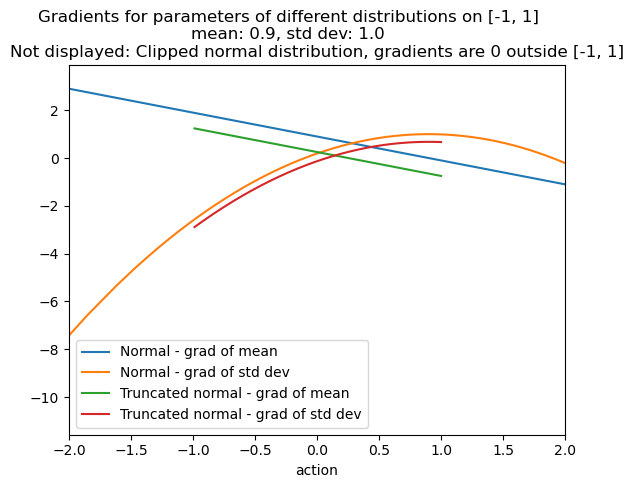

In [57]:
# Plotting the gradients

normal_actions = []
normal_meangrads = []
normal_stddevgrads = []

truncated_actions = []
truncated_meangrads = []
truncated_stddevgrads = []

m, s = 0.9, 1.0 # mean, standard deviation

l, u = -1, 1 # range

for i in range(1000):
    means   = torch.tensor(m, requires_grad=True)
    stddevs = torch.tensor(s, requires_grad=True)
    N = torch.distributions.Normal(means, stddevs)
    action = N.sample()
    log_prob = N.log_prob(action)
    loss = -log_prob
    loss.backward()
    normal_actions.append(action.item())
    normal_meangrads.append(means.grad.item())
    normal_stddevgrads.append(stddevs.grad.item())

    ################
    means   = torch.tensor([m], requires_grad=True)
    stddevs = torch.tensor([s], requires_grad=True)
    TN = TruncatedNormal(loc=means, scale=stddevs, low=-1, high=1, tanh_loc=False)
    action = TN.sample()
    log_prob = TN.log_prob(action)
    loss = -log_prob
    loss.backward()
    truncated_actions.append(action.item())
    truncated_meangrads.append(means.grad.item())
    truncated_stddevgrads.append(stddevs.grad.item())


normal_inds = np.array(normal_actions).argsort()
truncated_inds = np.array(truncated_actions).argsort()

fig, ax = plt.subplots(1, 1)

ax.plot(np.array(normal_actions)[normal_inds], np.array(normal_meangrads)[normal_inds], label="Normal - grad of mean")
ax.plot(np.array(normal_actions)[normal_inds], np.array(normal_stddevgrads)[normal_inds], label="Normal - grad of std dev")

ax.plot(np.array(truncated_actions)[truncated_inds], np.array(truncated_meangrads)[truncated_inds], label="Truncated normal - grad of mean")
ax.plot(np.array(truncated_actions)[truncated_inds], np.array(truncated_stddevgrads)[truncated_inds], label="Truncated normal - grad of std dev")

ax.set_xlim([l-1, u+1])

plt.title(f"Gradients for parameters of different distributions on [{l}, {u}] \
          \nmean: {m}, std dev: {s} \
          \nNot displayed: Clipped normal distribution, gradients are 0 outside [{l}, {u}]")
plt.xlabel("action")
plt.legend()
plt.show()